In [1]:
#!pip install spacy

In [2]:
import pandas as pd
import nltk
import re
from nltk import FreqDist
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import spacy

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import dask.dataframe as dd
import numpy as np

import gensim
from gensim.models import ldamodel
from prettytable import PrettyTable
from gensim import corpora
import csv

from gensim.models.coherencemodel import CoherenceModel

from gensim import corpora
from gensim.models import LdaModel
from gensim.models.ldamodel import CoherenceModel

In [3]:
col_name =['target','id','date','flag','user','tweet']# define column name
#tweet_df = pd.read_csv("https://drive.google.com/uc?id={}".format("1zElG1zb6KSq58jtAkDNLcYi5P6xd4G7g"), encoding="latin-1")
tweet_df = pd.read_csv("/content/tweet1.csv",names = col_name, encoding="latin-1")
tweet =tweet_df.iloc[:,[1,2,4,5]]

In [4]:
print("tweet:", tweet.tail(2), "", sep='\n')

tweet:
                 id                          date            user  \
1048571  1960186445  Fri May 29 07:33:44 PDT 2009  jonasobsessedx   
1048572  1960186607  Fri May 29 07:33:45 PDT 2009       sugababez   

                                          tweet  
1048571  @DestinyHope92 im great thaanks  wbuu?  
1048572    cant wait til her date this weekend   



In [5]:
#pre processing

In [6]:
        #remove Special haractors,links & convert to lower case

In [7]:
tweet['tweet'] = tweet['tweet'].apply(lambda x: re.sub(r'[^\w\s]|https?://\S+|www\.\S+]','',str(x)).lower())

<ipython-input-7-4f47575e873c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['tweet'] = tweet['tweet'].apply(lambda x: re.sub(r'[^\w\s]|https?://\S+|www\.\S+]','',str(x)).lower())


In [8]:
print(tweet)

                 id                          date             user  \
0        1467810369  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1        1467810672  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   
2        1467810917  Mon Apr 06 22:19:53 PDT 2009         mattycus   
3        1467811184  Mon Apr 06 22:19:57 PDT 2009          ElleCTF   
4        1467811193  Mon Apr 06 22:19:57 PDT 2009           Karoli   
...             ...                           ...              ...   
1048568  1960186342  Fri May 29 07:33:44 PDT 2009  Madelinedugganx   
1048569  1960186409  Fri May 29 07:33:43 PDT 2009     OffRoad_Dude   
1048570  1960186429  Fri May 29 07:33:44 PDT 2009         Falchion   
1048571  1960186445  Fri May 29 07:33:44 PDT 2009   jonasobsessedx   
1048572  1960186607  Fri May 29 07:33:45 PDT 2009        sugababez   

                                                     tweet  
0        switchfoot   awww thats a bummer  you shoulda ...  
1        is upset that he cant update

In [9]:
        #Tokenize the tweet column

In [10]:
nltk.download('punkt')#download NLTK data
tweet['tweet_tk'] =tweet['tweet'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-10-e7a51daa5e75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['tweet_tk'] =tweet['tweet'].apply(word_tokenize)


In [11]:
#remove Stop words

In [12]:
nltk.download('stopwords')#download stopword data
stop_words =set(stopwords.words('english'))
add_words =['lol','amp','oh','haha','fed','ugh','wan','gon','hoo','nap','nooo','chromachris clean','argh','un','sec','aah','dang','soooooo'
,'sigh','bro','whoo','clean house','aah','ughhh','ache','gm']
stop_words.update(add_words)#update stop words
tweet["tweet_flt"] =tweet['tweet_tk'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
#Lemmatize the words

In [14]:
nltk.download('wordnet')#Download the WorNet data
lemmatizer =WordNetLemmatizer()
tweet['tweet_lmtized'] = tweet['tweet_flt'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
#find frequent words

In [16]:
#creat list of words

In [17]:
tweet_words =[word for tokens in tweet['tweet_lmtized'] for word in tokens]

In [18]:
#calculate Sentiment Score
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [19]:
#count word frequencies
word_freq =Counter(tweet_words)

print(word_freq.most_common(10))

[('im', 125282), ('day', 66981), ('get', 59145), ('go', 56589), ('like', 52995), ('work', 52430), ('dont', 51959), ('cant', 49315), ('good', 48457), ('got', 47422)]


In [20]:
# Get the most common words (e.g., top 10)
most_common_words = [word for word, count in word_freq.most_common(50000)]

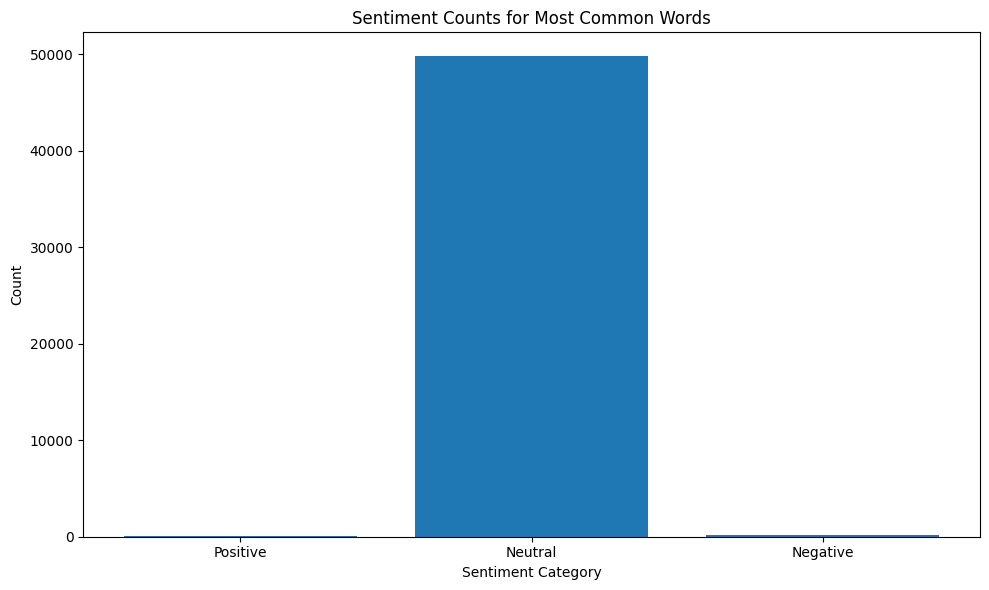

<Figure size 640x480 with 0 Axes>

In [21]:
# Perform sentiment analysis for most common words and categorize
sentiments = {word: SentimentIntensityAnalyzer().polarity_scores(word) for word in most_common_words}
# catagarize positive, negative, and neutral counts
positive_count = 0
negative_count = 0
neutral_count = 0

# gete most common words and count
for word in most_common_words:
    # Perform sentiment analysis or any other criteria to categorize words
    if 'good' in word or 'happy' in word:  # Example criteria for positive sentiment
        positive_count += 1
    elif 'bad' in word or 'sad' in word:   # Example criteria for negative sentiment
        negative_count += 1
    else:
        neutral_count += 1

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot
categories = ['Positive', 'Neutral', 'Negative']
counts = [positive_count, neutral_count, negative_count]
plt.bar(categories, counts)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Counts for Most Common Words')
plt.tight_layout()

plt.show()
plt.savefig('sentiment_counts.jpg', format='jpg', dpi=300)

In [22]:
#Add stopword
#stop_words =set(stopwords.words('english'))
#add_words =['im','day', 'good', 'get', 'like', 'go', 'got', 'u', 'love', 'dont','work','cant','today','back','one','lol','know'
 #          ,'really','going','time','want','see','well','think','night','still','new','na','amp','need','thanks','home','oh',
 #          'miss','much','last','feel','make','2','morning','tomorrow','great','ill','thats','haha','fed','ugh','house','wan',
 #           'gon','hoo','nap','nooo','chromachris clean','argh','bro','un','sec']
#stop_words.update(add_words)
#tweet["tweet_flt"] =tweet['tweet_tk'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

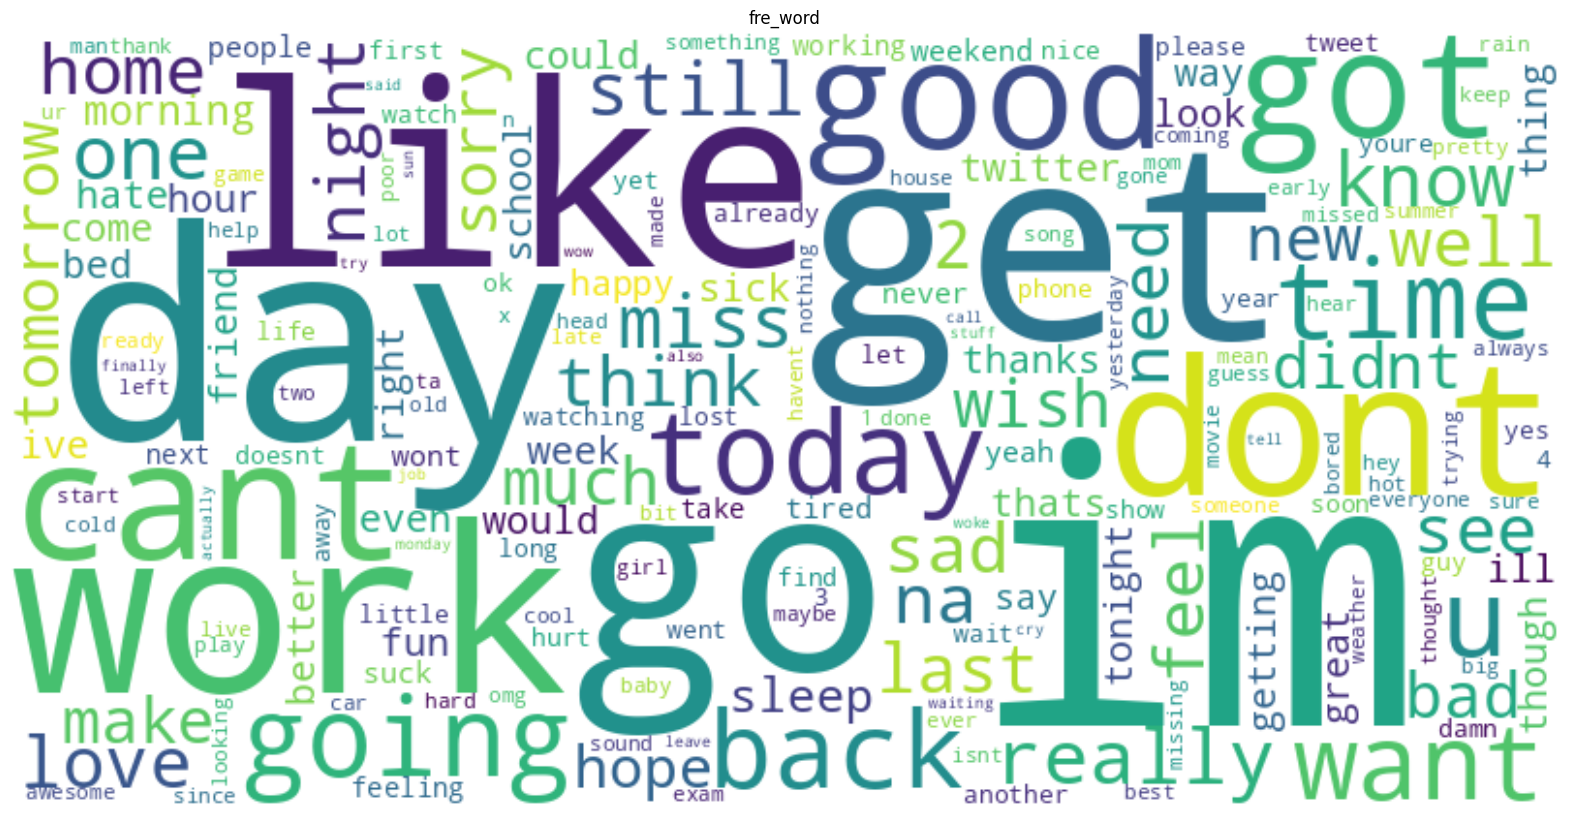

<Figure size 640x480 with 0 Axes>

In [23]:
#wordcloud
wordcloud =WordCloud(width =800, height=400, background_color ='white').generate_from_frequencies(word_freq)
#plot
plt.figure(figsize=(20,18))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('fre_word')
cloud1 = plt.gcf()
plt.show()
plt.draw()
cloud1.savefig('cloud1.jpg', dpi=100)

In [24]:
#preform topic modeling

In [25]:
#combine tokenback
tweet['tweet_final'] =tweet['tweet_lmtized'].apply(lambda tokens: ' '.join(tokens))

In [26]:
#load the "en_core_web_sm" model
nlp = spacy.load("en_core_web_sm")

In [27]:
#crate a function for identify and extract brands
def extract_brands(text):
    doc = nlp(text)
    brands = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return brands

tweet['brands'] = tweet['tweet_final'].apply(extract_brands)


In [28]:
print(tweet[['tweet','brands']])

                                                     tweet brands
0        switchfoot   awww thats a bummer  you shoulda ...     []
1        is upset that he cant update his facebook by t...     []
2        kenichan i dived many times for the ball manag...     []
3          my whole body feels itchy and like its on fire      []
4        nationwideclass no its not behaving at all im ...     []
...                                                    ...    ...
1048568           my grandma is making dinenr with my mum      []
1048569  midmorning snack time a bowl of cheese noodles...     []
1048570  shadela same here  say it like from the termin...     []
1048571               destinyhope92 im great thaanks  wbuu     []
1048572               cant wait til her date this weekend      []

[1048573 rows x 2 columns]


In [29]:
#tweet.to_csv('/content/tweet2.csv', index=False)


In [30]:
#creat list of words

In [31]:
tweet_words_after =[word for tokens in tweet['brands'] for word in tokens]

#count word frequencies
word_freq_after =Counter(tweet_words_after)
#print
print(word_freq_after.most_common(10))

[('mtv', 418), ('google', 371), ('house', 341), ('air france', 327), ('vista', 231), ('sony', 193), ('microsoft', 193), ('bbc', 183), ('taco', 176), ('justin', 176)]


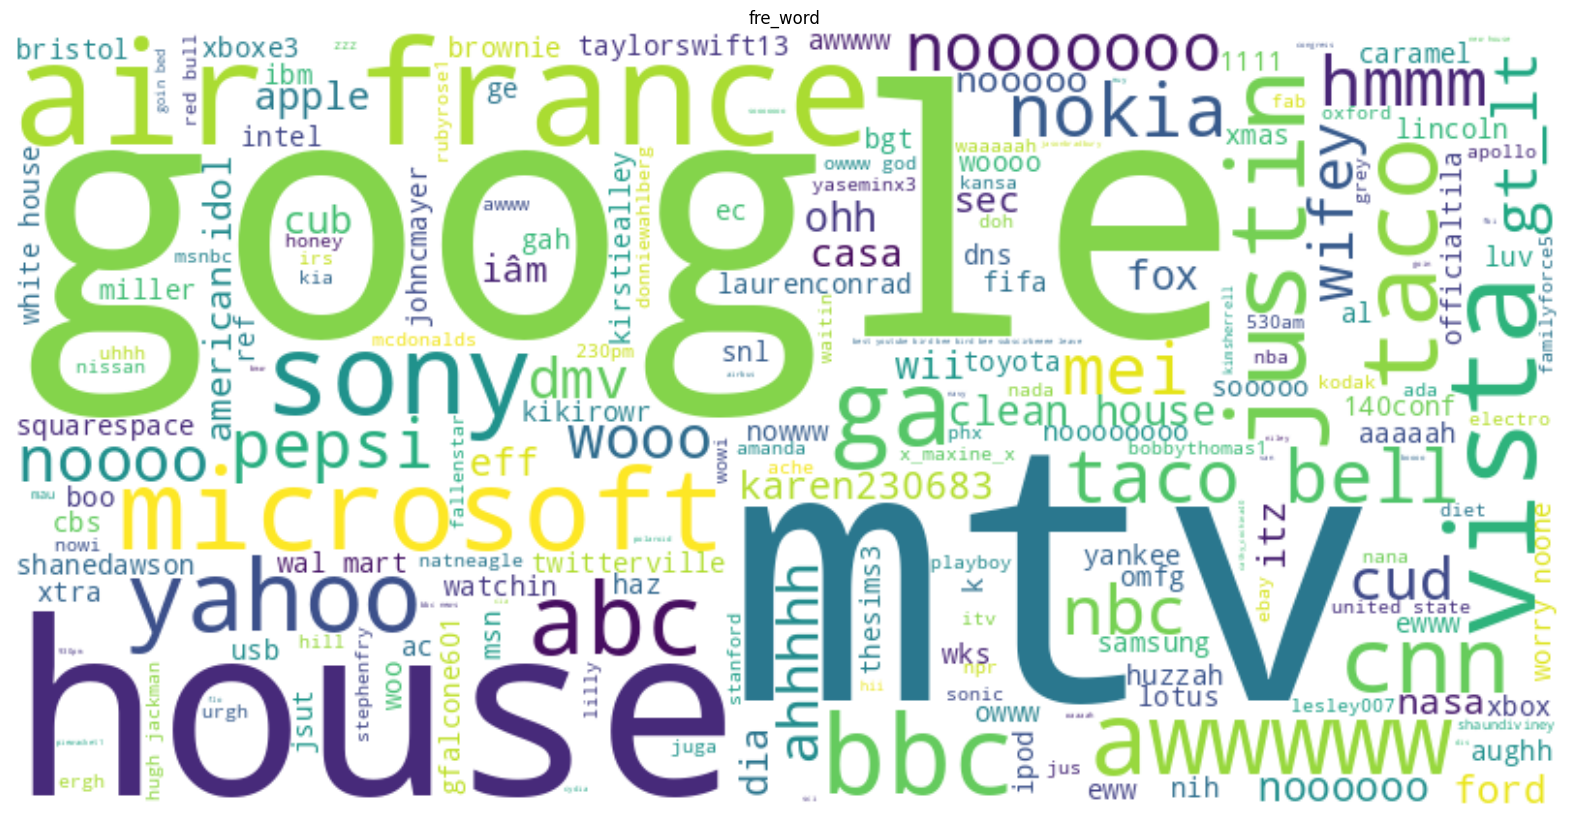

In [32]:
#wordcloud after extract brand
wordcloud_after =WordCloud(width =800, height=400, background_color ='white').generate_from_frequencies(word_freq_after)
#plot
plt.figure(figsize=(20,18))
plt.imshow(wordcloud_after,interpolation='bilinear')
plt.axis('off')
plt.title('fre_word')
plt.show()

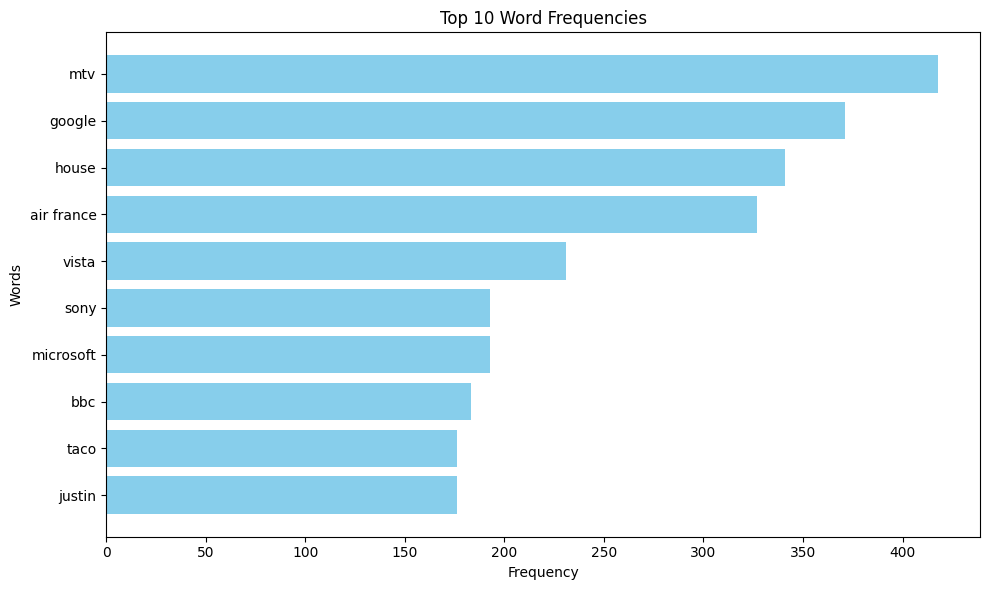

In [33]:
# Get the top 10 words and frequencies
top_words = [word[0] for word in word_freq_after.most_common(10)]
word_counts = [word[1] for word in word_freq_after.most_common(10)]

# plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words, word_counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Word Frequencies')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [34]:
# Perform sentiment analysis on the most common words
#sentiments = {word: SentimentIntensityAnalyzer().polarity_scores(word) for word in most_common_words}

# Prepare data for plotting
#words = list(sentiments.keys())
#positive_scores = [sentiment['pos'] for sentiment in sentiments.values()]
#negative_scores = [sentiment['neg'] for sentiment in sentiments.values()]
#neutral_scores = [sentiment['neu'] for sentiment in sentiments.values()]

# Set the figure size
#plt.figure(figsize=(10, 6))

# Create a grouped bar plot for positive, negative, and neutral sentiment scores
#bar_width = 0.3
#plt.bar([i - bar_width for i in range(len(words))], positive_scores, width=bar_width, label='Positive')
#plt.bar([i for i in range(len(words))], neutral_scores, width=bar_width, label='Neutral')
#plt.bar([i + bar_width for i in range(len(words))], negative_scores, width=bar_width, label='Negative')
#plt.xlabel('Words')
#plt.ylabel('Sentiment Score')
#plt.title('Sentiment Analysis for Most Common Words')
#plt.xticks(range(len(words)), words, rotation=45, ha="right")
#plt.legend()
#plt.tight_layout()

#plt.show()

In [35]:
#Try to plot word frequence in day wise
#create a dataframe with date and brands
tweet_trend =pd.DataFrame(tweet[['date','brands']])

In [36]:
#convert date type
tweet_trend['date'] =pd.to_datetime(tweet_trend['date'])

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [37]:
#df = tweet_trend.drop(tweet_trend[tweet_trend['brands'] == 'bro'].index)

In [38]:
# Flatten the list of brands and count occurrences
all_brands = [brand for brands_list in tweet_trend['brands'] for brand in brands_list]
brand_counts = pd.Series(all_brands).value_counts()

In [39]:
# Select the top 10 brands
top_10_brands = brand_counts.head(10).index

In [40]:
# Filter data for top 10 brands
tweet_trend['top_brands'] = tweet_trend['brands'].apply(lambda brands: [brand for brand in brands if brand in top_10_brands])
# Filter out rows with empty 'top_brands' lists
tweet_trend = tweet_trend[tweet_trend['top_brands'].apply(len) > 0]

In [41]:
# Group by date and brand, then count occurrences
brand_counts_by_date = tweet_trend.explode('top_brands').groupby(['date', 'top_brands']).size().unstack().fillna(0)

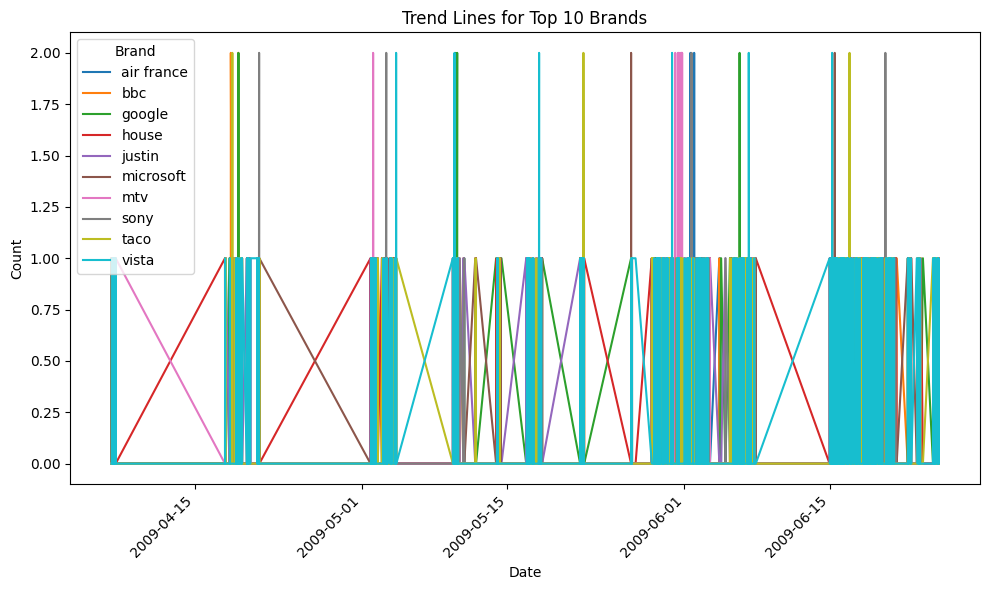

In [42]:
# Plot trend lines for top 10 brands
plt.figure(figsize=(10, 6))
brand_counts_by_date.plot(kind='line', ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trend Lines for Top 10 Brands')
plt.legend(title='Brand')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

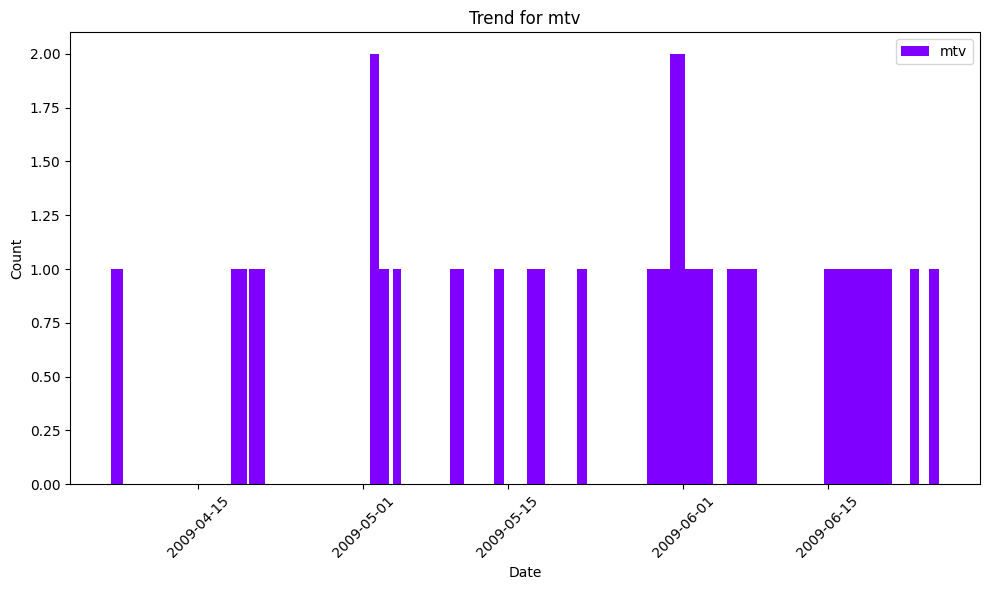

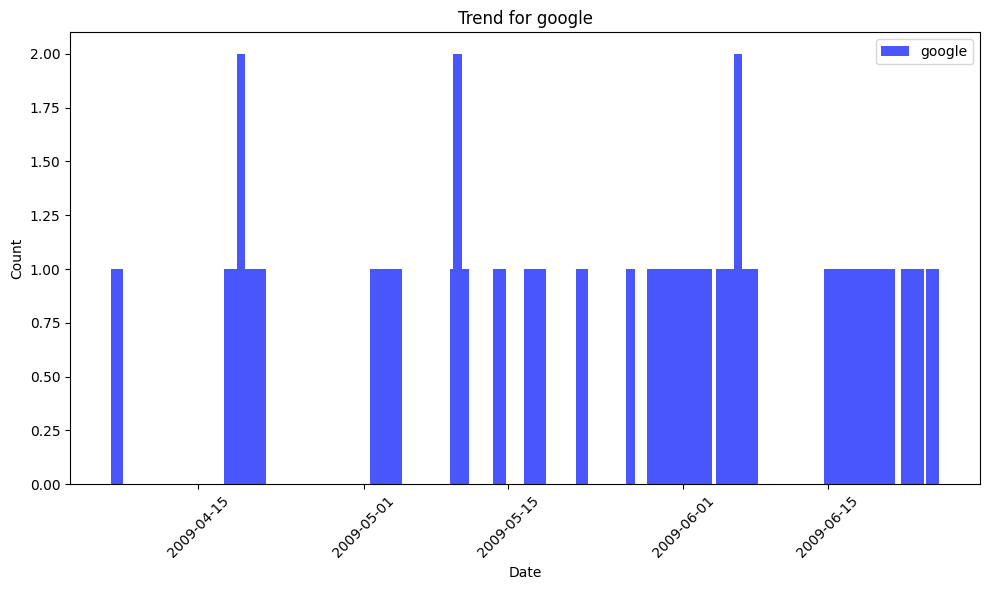

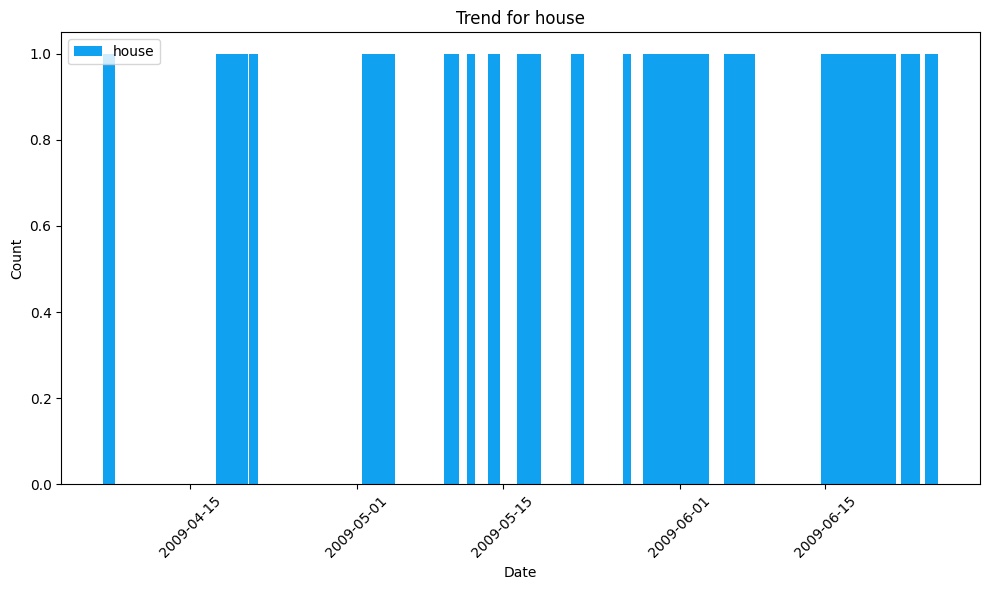

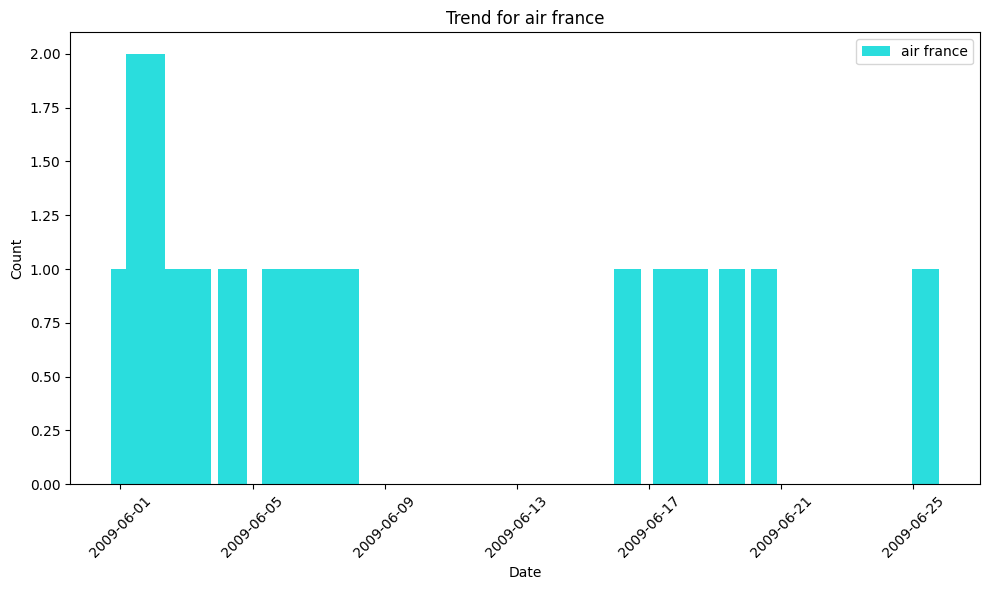

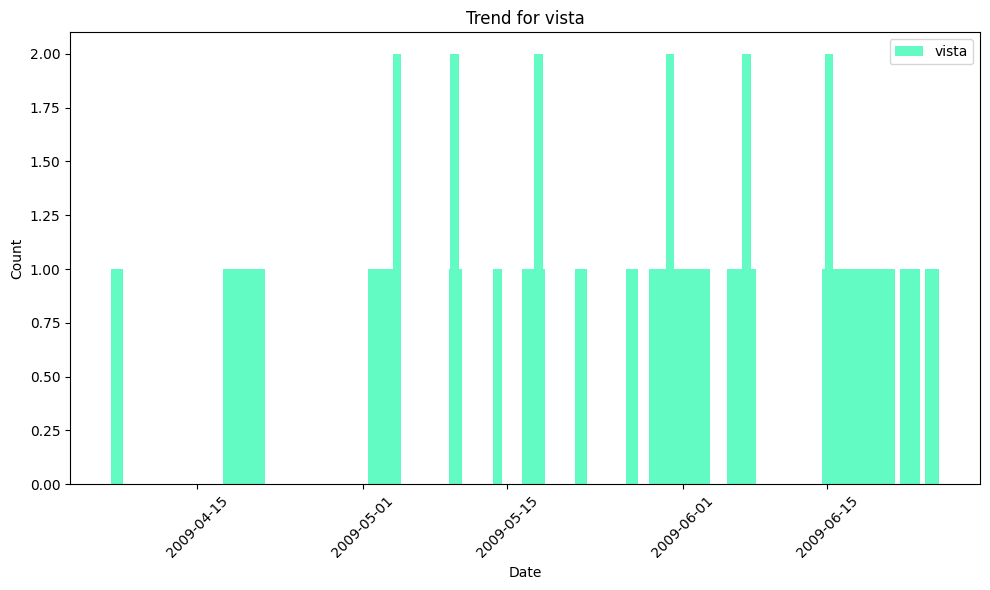

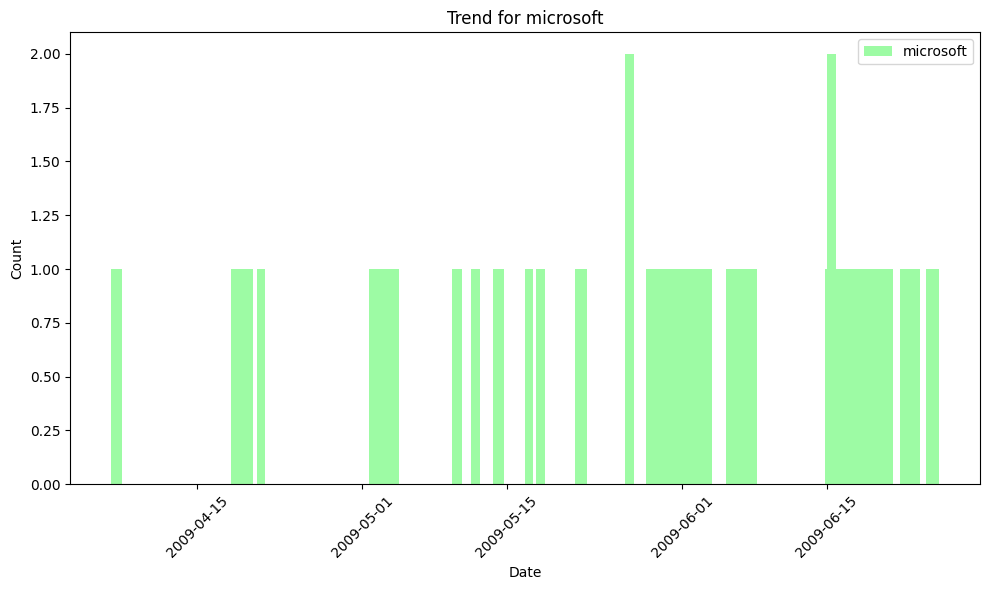

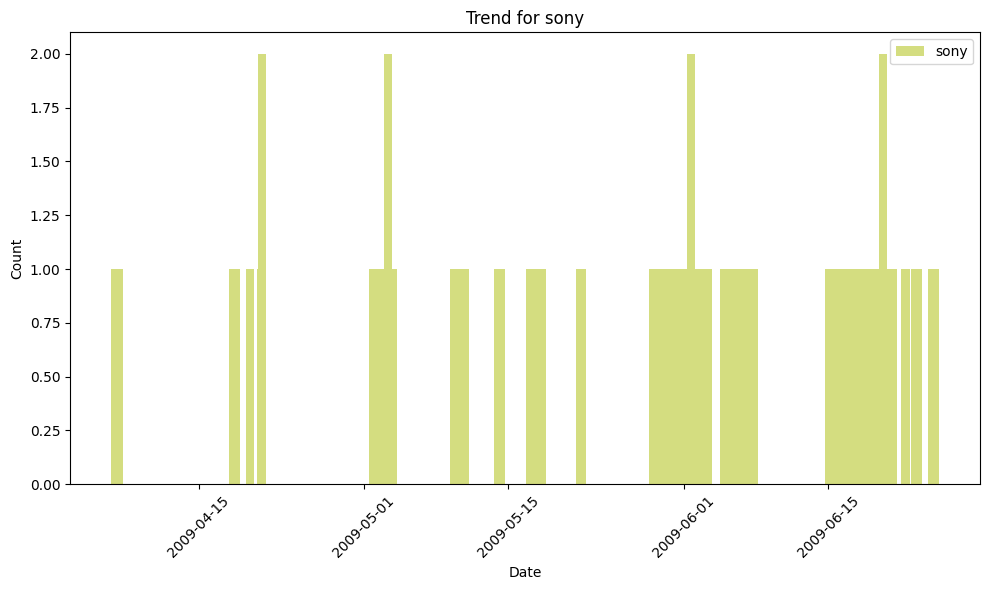

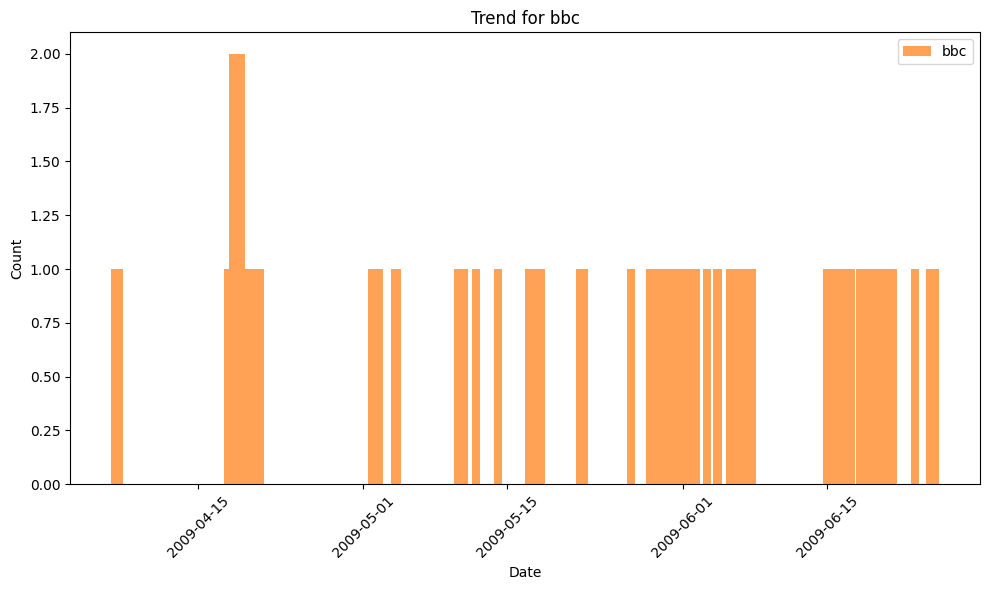

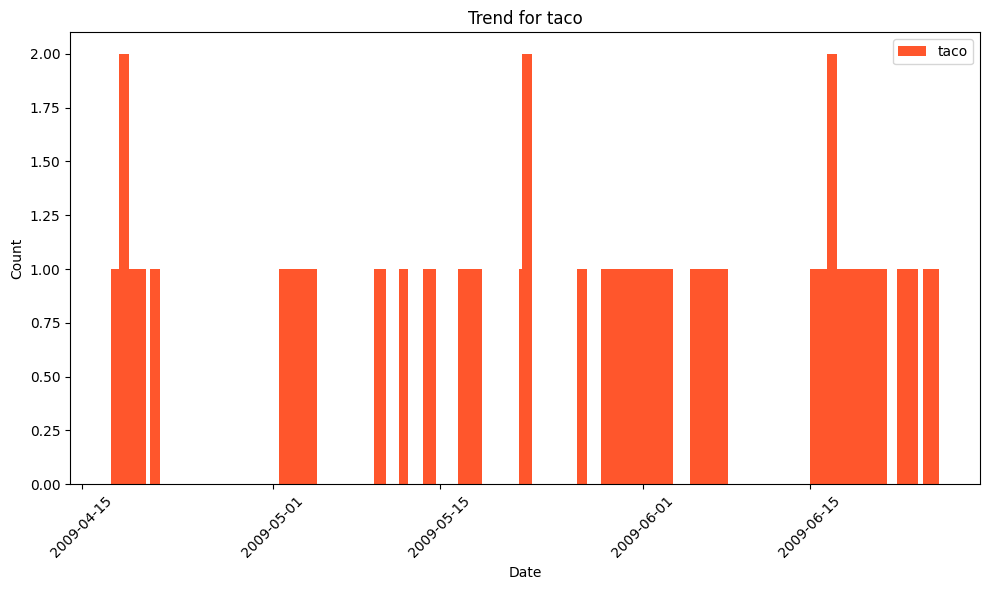

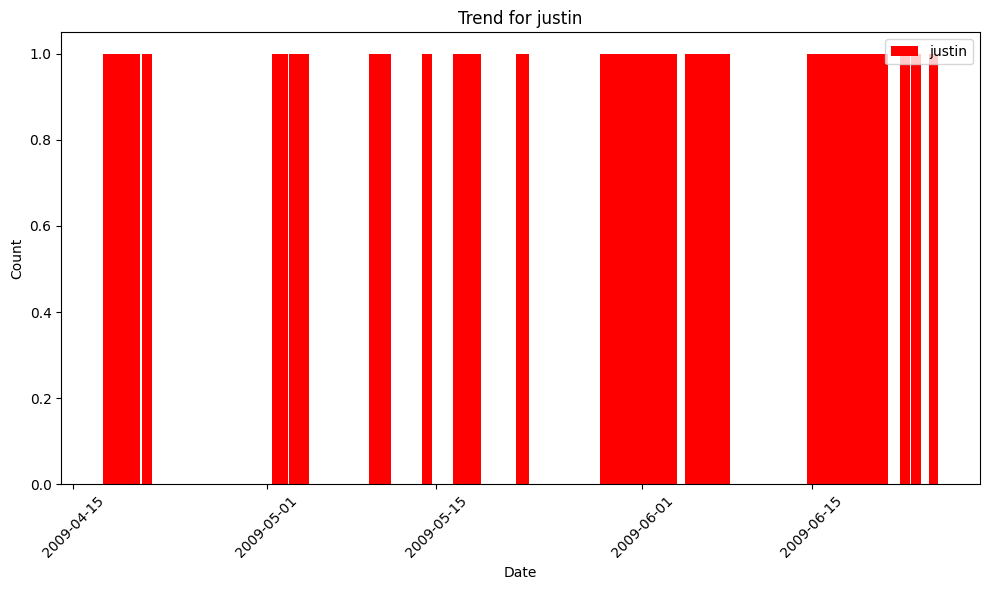

In [43]:
#plot top 10 brand separately
# Define a list of colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(top_10_brands)))
# Plot each brand separately with different colors
for brand, color in zip(top_10_brands, colors):
    brand_data = brand_counts_by_date[brand]
    plt.figure(figsize=(10, 6))
    plt.bar(brand_data.index[brand_data.values != 0], brand_data.values[brand_data.values != 0], label=brand, color=color)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title(f'Trend for {brand}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [44]:
#user wise
#tewwt_user =pd.DataFrame(tweet[['user','brands']])

# Flatten the list of brands and count occurrences
#all_brands = [brand for brands_list in tewwt_user['brands'] for brand in brands_list]
#brand_counts = pd.Series(all_brands).value_counts()

# Select the top 10 brands
#top_10_brands = brand_counts.head(10).index

# Filter data for top 10 brands
#tewwt_user['top_brands'] = tewwt_user['brands'].apply(lambda brands: [brand for brand in brands if brand in top_10_brands])

In [45]:
#brand wise Sentiment Analysis_MTV

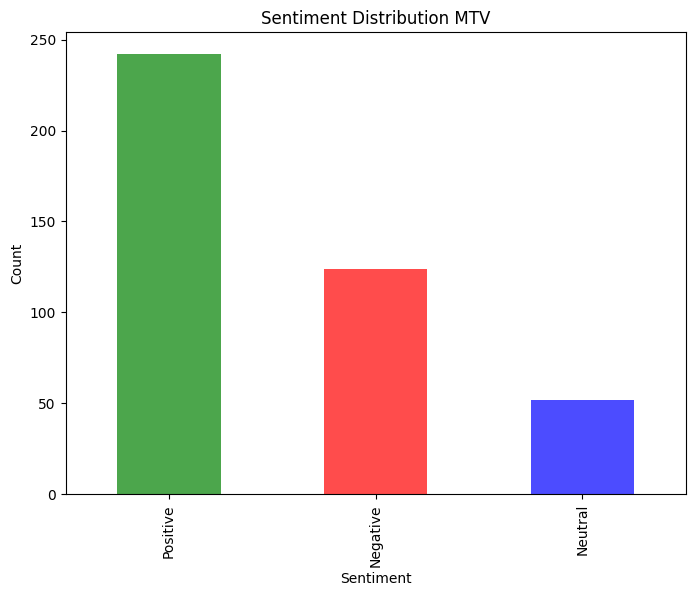

Positive    242
Negative    124
Neutral      52
Name: sentiment, dtype: int64

In [46]:
# Flatten the list of brands
tweet_mtv = tweet.explode('brands')

# Filter to include only rows where 'brands' is equal to 'mtv'
tweet_mtv = tweet_mtv[tweet_mtv['brands'] == 'mtv'][['tweet', 'brands']]

# Display the resulting DataFrame
#print(tweet_mtv)
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each tweet for MTV
tweet_mtv['sentiment'] = tweet_mtv['tweet'].apply(lambda text: 'Positive' if analyzer.polarity_scores(text)['compound'] >= 0.05
                                          else ('Negative' if analyzer.polarity_scores(text)['compound'] <= -0.05
                                                else 'Neutral'))
# Count the number of tweets in each sentiment category
sentiment_counts_MTV = tweet_mtv['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts_MTV.plot(kind='bar', color=['green', 'red', 'blue'], alpha=0.7)
plt.title('Sentiment Distribution MTV')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()
sentiment_counts_MTV

In [47]:
#brand wise Sentiment Analysis_Google

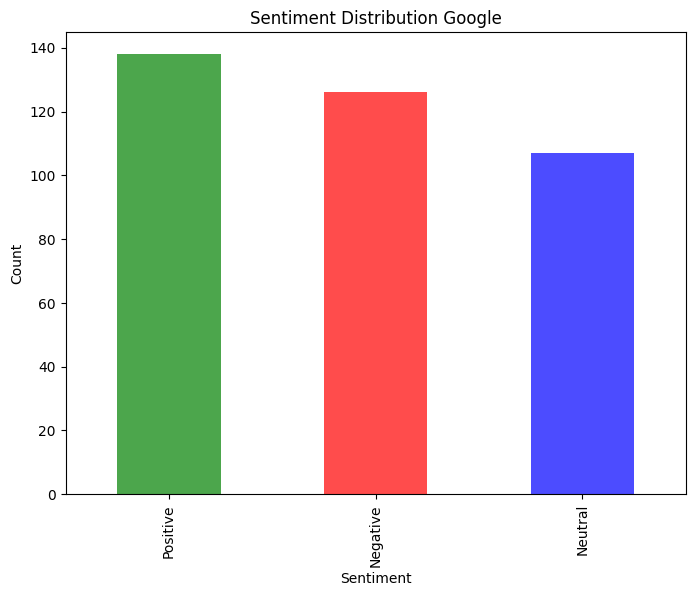

Positive    138
Negative    126
Neutral     107
Name: sentiment, dtype: int64

In [48]:
# Flatten the list of brands
tweet_google = tweet.explode('brands')

# Filter to include only rows where 'brands' is equal to 'google'
tweet_google = tweet_google[tweet_google['brands'] == 'google'][['tweet', 'brands']]

# Display the resulting DataFrame
#print(tweet_google)
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each tweet for google
tweet_google['sentiment'] = tweet_google['tweet'].apply(lambda text: 'Positive' if analyzer.polarity_scores(text)['compound'] >= 0.05
                                          else ('Negative' if analyzer.polarity_scores(text)['compound'] <= -0.05
                                                else 'Neutral'))
# Count the number of tweets in each sentiment category
sentiment_counts_google = tweet_google['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts_google.plot(kind='bar', color=['green', 'red', 'blue'], alpha=0.7)
plt.title('Sentiment Distribution Google')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()
sentiment_counts_google

In [49]:
#brand wise Sentiment Analysis_house

In [50]:
# Flatten the list of brands
tweet_house = tweet.explode('brands')

# Filter to include only rows where 'brands' is equal to 'house'
tweet_house = tweet_house[tweet_house['brands'] == 'house'][['tweet', 'brands']]

# Display the resulting DataFrame
#print(tweet_house)
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each tweet for house
tweet_house['sentiment'] = tweet_house['tweet'].apply(lambda text: 'Positive' if analyzer.polarity_scores(text)['compound'] >= 0.05
                                          else ('Negative' if analyzer.polarity_scores(text)['compound'] <= -0.05
                                                else 'Neutral'))


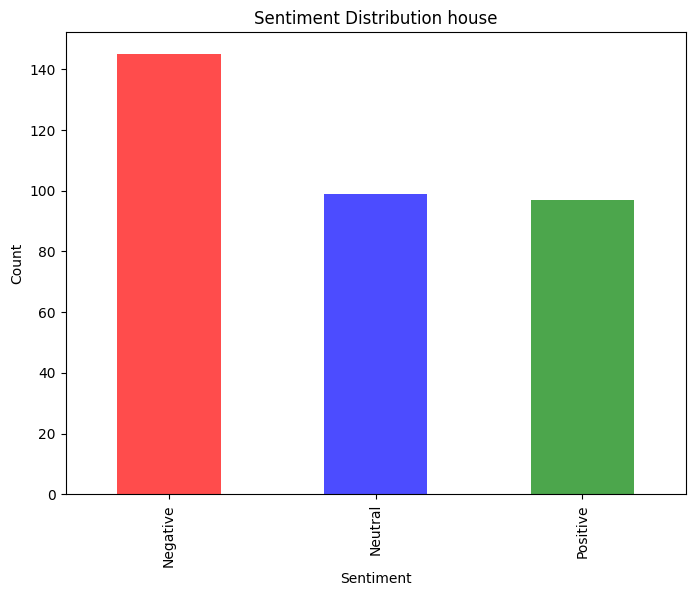

Negative    145
Neutral      99
Positive     97
Name: sentiment, dtype: int64

In [51]:
# Count the number of tweets in each sentiment category
sentiment_counts_house = tweet_house['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts_house.plot(kind='bar', color=['red','blue','green'], alpha=0.7)
plt.title('Sentiment Distribution house')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()
sentiment_counts_house

In [52]:
#brand wise Sentiment Analysis_airfrance

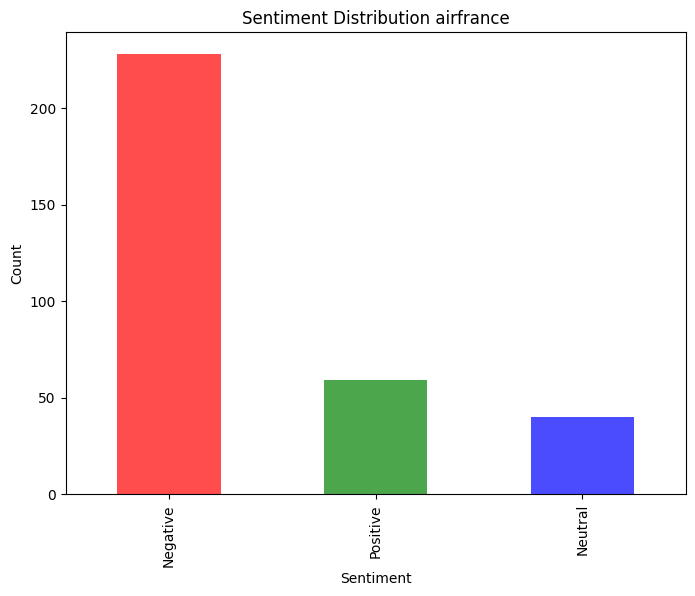

Negative    228
Positive     59
Neutral      40
Name: sentiment, dtype: int64

In [53]:
# Flatten the list of brands
tweet_airfrance = tweet.explode('brands')

# Filter to include only rows where 'brands' is equal to 'airfrance'
tweet_airfrance = tweet_airfrance[tweet_airfrance['brands'] == 'air france'][['tweet', 'brands']]

# Display the resulting DataFrame
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each tweet for airfrance
tweet_airfrance['sentiment'] = tweet_airfrance['tweet'].apply(lambda text: 'Positive' if analyzer.polarity_scores(text)['compound'] >= 0.05
                                          else ('Negative' if analyzer.polarity_scores(text)['compound'] <= -0.05
                                                else 'Neutral'))
# Count the number of tweets in each sentiment category
sentiment_counts_airfrance = tweet_airfrance['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts_airfrance.plot(kind='bar', color=['red','green' , 'blue'], alpha=0.7)
plt.title('Sentiment Distribution airfrance')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()
sentiment_counts_airfrance

In [54]:
#brand wise Sentiment Analysis_vista

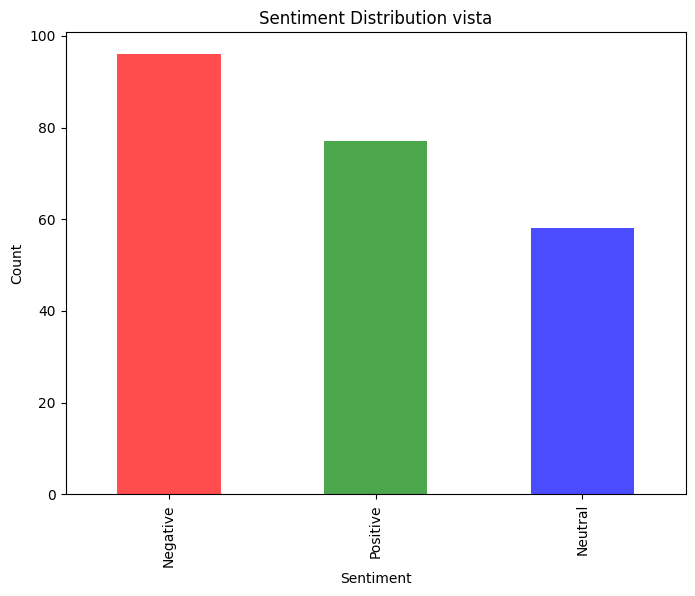

Negative    96
Positive    77
Neutral     58
Name: sentiment, dtype: int64

In [55]:
# Flatten the list of brands
tweet_vista = tweet.explode('brands')

# Filter to include only rows where 'brands' is equal to 'vista'
tweet_vista = tweet_vista[tweet_vista['brands'] == 'vista'][['tweet', 'brands']]

# Display the resulting DataFrame
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each tweet for vista
tweet_vista['sentiment'] = tweet_vista['tweet'].apply(lambda text: 'Positive' if analyzer.polarity_scores(text)['compound'] >= 0.05
                                          else ('Negative' if analyzer.polarity_scores(text)['compound'] <= -0.05
                                                else 'Neutral'))
# Count the number of tweets in each sentiment category
sentiment_counts_vista = tweet_vista['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts_vista.plot(kind='bar', color=['red','green' , 'blue'], alpha=0.7)
plt.title('Sentiment Distribution vista')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()
sentiment_counts_vista

In [56]:
#preform Topic molding
topic_mold =pd.DataFrame(tweet_trend['top_brands'])
# Filter out rows with non-empty brand lists
topic_mold = topic_mold[topic_mold['top_brands'].apply(lambda brands: len(brands) > 0)]
print(topic_mold)

          top_brands
803         [google]
1092        [google]
1387           [mtv]
1900         [house]
2114         [house]
...              ...
1047919      [house]
1047958      [vista]
1047972  [microsoft]
1048190     [google]
1048283     [google]

[2567 rows x 1 columns]


In [57]:
# Create a dictionary
dictionary = gensim.corpora.Dictionary(topic_mold['top_brands'])

In [58]:
# Create a corpus
corpus = [dictionary.doc2bow(text) for text in topic_mold['top_brands']]

In [61]:
# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=20, iterations=1000)

In [62]:
# Assign names to the topics based on keyword analysis
topic_names = {
    0: "Technology and Entertainment",
    1: "News and Media",
    2: "Experiences "
}

# Create a PrettyTable to display topics
table = PrettyTable(['Topic ID', 'Topic Name', 'Keywords'])

# Print the topics with assigned names
topics = lda_model.print_topics()
for topic_id, topic in topics:
    topic_name = topic_names.get(topic_id, "Unknown")
    table.add_row([topic_id, topic_name, topic])

# Set the align of the columns
table.align['Topic ID'] = 'l'
table.align['Topic Name'] = 'l'
table.align['Keywords'] = 'l'

# Print the table
print(table)

+----------+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Topic ID | Topic Name                   | Keywords                                                                                                                                                           |
+----------+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| 0        | Technology and Entertainment | 0.506*"google" + 0.249*"taco" + 0.242*"microsoft" + 0.000*"vista" + 0.000*"bbc" + 0.000*"house" + 0.000*"air france" + 0.000*"sony" + 0.000*"justin" + 0.000*"mtv" |
| 1        | News and Media               | 0.398*"mtv" + 0.328*"justin" + 0.271*"sony" + 0.000*"vista" + 0.000*"house" + 0.000*"air france" + 0.000*"bbc" + 0.000*"

In [63]:
from prettytable import PrettyTable
# Convert the PrettyTable to a pandas DataFrame
data = []
for row in table:
    data.append(row)
df = pd.DataFrame(data[1:], columns=data[0])

# Export the DataFrame to an Excel file
excel_file = "topics.xlsx"  # Specify the file name
df.to_excel(excel_file, index=False)

print(f"Table exported to {excel_file}")

Table exported to topics.xlsx
